In [217]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pydot
from IPython.display import SVG
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [11]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-07-12 09:25:10--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   135MB/s    in 0.6s    

2020-07-12 09:25:10 (135 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [6]:
from google.colab import files 
uploaded = files.upload()

Saving train_SOaYf6m.zip to train_SOaYf6m.zip


In [ ]:
!unzip train_SOaYf6m.zip

In [8]:
df = pd.read_csv('train.csv')
df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [40]:
df.shape

(1646, 2)

In [43]:
df['emergency_or_not'].value_counts()

0    965
1    681
Name: emergency_or_not, dtype: int64

(224, 224)


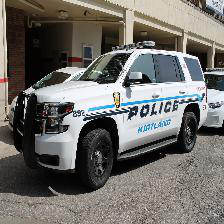

In [51]:
sample_image = 'images/45.jpg'
img1 = Image.open(sample_image)
print(img1.size)
img1


In [23]:
for e in ['emergency', 'non_emergency']:
  os.makedirs(f'training/{e}')
  os.makedirs(f'validation/{e}')

In [50]:
for row in df.head(10).itertuples():
  print(row.image_names, row.emergency_or_not, type(row.emergency_or_not))

1503.jpg 0 <class 'int'>
1420.jpg 0 <class 'int'>
1764.jpg 0 <class 'int'>
1356.jpg 0 <class 'int'>
1117.jpg 0 <class 'int'>
45.jpg 1 <class 'int'>
2313.jpg 0 <class 'int'>
1657.jpg 0 <class 'int'>
294.jpg 1 <class 'int'>
999.jpg 0 <class 'int'>


## Separate images into training and validation directories

In [46]:
for row in df.itertuples():
  src = f'images/{row.image_names}'
  prob = np.random.randint(0,10)
  typ = 'training' if 0 <= prob < 8 else 'validation'
  label = 'emergency' if row.emergency_or_not else 'non_emergency'
  dst = f'{typ}/{label}/{row.image_names}'
  copyfile(src, dst)

In [47]:
print(len(os.listdir('training/emergency')))
print(len(os.listdir('training/non_emergency')))
print(len(os.listdir('validation/emergency')))
print(len(os.listdir('validation/non_emergency')))

539
793
142
172


In [49]:
train_dir = 'training'
validation_dir = 'validation'

train_emergency_dir = 'training/emergency'
train_non_emergency_dir = 'training/non_emergency'
validation_emergency_dir = 'validation/emergency'
validation_non_emergency_dir = 'validation/non_emergency'

In [54]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(rescale=1./255.0)

In [55]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=16,
    target_size=(224,224),
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size=16,
    target_size=(224,224),
    class_mode='binary'
)

Found 1332 images belonging to 2 classes.
Found 314 images belonging to 2 classes.


In [118]:
print(train_generator.class_indices)

{'emergency': 0, 'non_emergency': 1}


In [117]:
print(validation_generator.class_indices)

{'emergency': 0, 'non_emergency': 1}


## Visualise the images

In [103]:
sample_training_images, _ = next(train_generator)

In [104]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

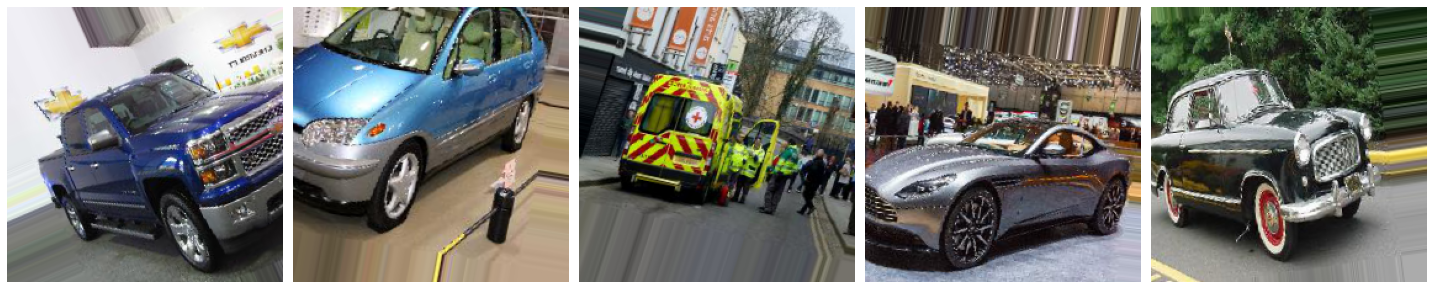

In [105]:
plotImages(sample_training_images[:5])


## Transfer Learning using Inception model

In [ ]:
path_inception = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
    
# Print the model summary
pre_trained_model.summary()

In [66]:
last_layer = pre_trained_model.get_layer('mixed9')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


In [225]:
X = tf.keras.layers.Flatten()(last_output)
X = tf.keras.layers.Dense(1024, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(512, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)

In [ ]:
model = Model(pre_trained_model.input, X)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [226]:
EPOCHS = 50

In [227]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
model_ckpt = tf.keras.callbacks.ModelCheckpoint('model-{epoch}.h5', period=5)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_ckpt])

Epoch 1/50
84/84 [==============================] - 194s 2s/step - loss: 0.1508 - accuracy: 0.9444 - val_loss: 0.1388 - val_accuracy: 0.9490
Epoch 2/50
13/84 [===>..........................] - ETA: 2:08 - loss: 0.2161 - accuracy: 0.9279

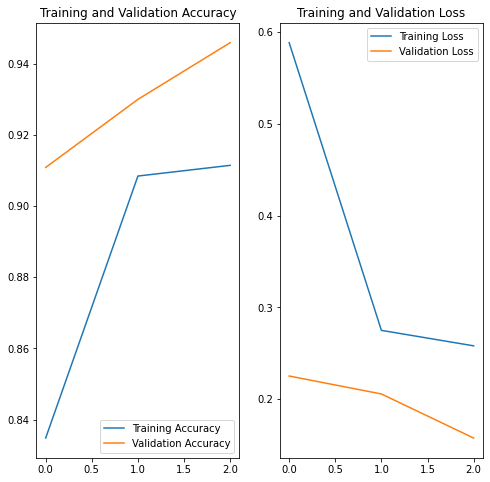

In [109]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction on Test

In [169]:
sample = pd.read_csv('sample_submission.csv')
print(sample.shape)
sample.head()

(706, 2)


,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


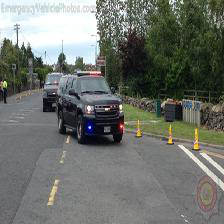

In [204]:
sample_image = 'images/668.jpg'
Image.open(sample_image)

In [205]:
test_images = np.zeros((1,224,224,3))

#### Vertically stack the test images

In [206]:
for row in sample.itertuples():
  image_name = f'images/{row.image_names}'
  img = np.asarray(Image.open(image_name))
  img = np.expand_dims(img, axis=0)
  test_images = np.vstack((test_images, img))

In [207]:
test_images.shape

(707, 224, 224, 3)

In [208]:
test_images = test_images[1:]
test_images.shape

(706, 224, 224, 3)

#### Rescale the images

In [209]:
test_images /= 255.0

*Below commented is incase the test images are to be read from a directory*

In [149]:
# for row in sample.itertuples():
#   src = f'images/{row.image_names}'
#   dst = f'testing/{row.image_names}'
#   copyfile(src, dst)

In [152]:
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [155]:
# test_generator = test_datagen.flow_from_direcctory(
#     '.',
#     test_images,
#     target_size=(224,224),
#     batch_size=1,
#     shuffle=False,
#     class_mode='binary'
# )

Found 706 images belonging to 1 classes.


#### Start predictions

In [210]:
pred = model.predict(test_images, batch_size=16)

In [211]:
pred.shape

(706, 1)

In [161]:
pred_copy = np.copy(pred)

In [212]:
pred = [0 if val > 0.5 else 1 for val in pred]

In [213]:
pred[:10]

[0, 1, 0, 1, 0, 1, 0, 1, 0, 0]

In [214]:
sample['emergency_or_not'] = pred

In [215]:
sample.to_csv('inception-3-epoch.csv', index=False)